# Logistic regression with pystan

In this notebook, we use PyStan to classify synthetic data. We have included the examples for:
 1. Binary univariate classification
 2. Binary bivariate classification

## 0. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import stan
import arviz as az

In [2]:
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

## 1. Binary univariate classification

In [3]:
N = 50

In [4]:
#generate two types of data
x1 = np.random.normal(2.5, 1, N)
x2 = np.random.normal(4, 1, N)
data = pd.DataFrame([x1, x2]).T
data.head()

,0,1
0,1.471750,4.073716
1,2.226489,3.665734
2,3.043140,4.506926
3,3.856841,5.429915
4,4.510419,4.321881


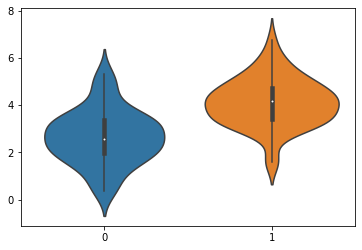

In [5]:
sns.violinplot(data=data)
plt.show()

In [6]:
x_0 = np.concatenate([x1, x2]).reshape((2*N, 1))
y_0 = np.concatenate([np.zeros(N), np.ones(N)]).astype(int)

In [7]:
code = """                                                                                         
data {                                                                                               
  int N; //the number observations                                                                                                                 
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix  
}                                                                                                    
parameters {                                                                                         
  real alpha;                                                                                        
  vector[K] beta; //the regression parameters                                                        
}                                                                                                    
transformed parameters {                                                                             
  vector[N] linpred;                                                                                 
  linpred = alpha+X*beta; 
  #vector[N] bd;
  #bd = -alpha/beta;
}                                                                                                    
model {                                                                                              
  alpha ~ normal(0,10); //prior for the intercept following Gelman 2008                              
                                                                                                   
  for(i in 1:K)                                                                                      
    beta[i] ~ normal(0,10);                                                                 
                                                                                                   
  y ~ bernoulli_logit(linpred);                                                                      
}                                                                                                                                                                                                       
"""  

In [8]:
y_0.shape, x_0.shape

((100,), (100, 1))

In [9]:
data = {                                                                                             
    'N': 2*N,                                                                                        
    'K': 1,                                                                                        
    'y': y_0,                                                                                     
    'X': x_0                                                                                             
}  

In [10]:
posterior = stan.build(code, data=data, random_seed=1)


Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 15, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 16, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be do

In [11]:
fit = posterior.sample(num_chains=2, num_samples=1000)


Sampling:   0%
Sampling:  50% (2000/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 7.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.76 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!


In [12]:
df = fit.to_frame()  # pandas `DataFrame, requires pandas
print(df.describe().T)

                count       mean       std        min        25%        50%  \
parameters                                                                    
lp__           2000.0 -51.376512  1.080322 -57.594872 -51.752542 -50.995879   
accept_stat__  2000.0   0.925874  0.112192   0.253347   0.904686   0.973577   
stepsize__     2000.0   0.168835  0.014489   0.154349   0.154349   0.168835   
treedepth__    2000.0   2.623500  0.958753   1.000000   2.000000   3.000000   
n_leapfrog__   2000.0  10.038000  7.389578   1.000000   3.000000   7.000000   
...               ...        ...       ...        ...        ...        ...   
linpred.96     2000.0   2.039062  0.503730   0.488865   1.695633   1.988700   
linpred.97     2000.0   0.200204  0.244979  -0.656454   0.035502   0.196399   
linpred.98     2000.0   0.235791  0.246327  -0.618348   0.071571   0.229595   
linpred.99     2000.0   4.388341  0.987175   1.385006   3.723282   4.281623   
linpred.100    2000.0   1.772299  0.453285   0.38710

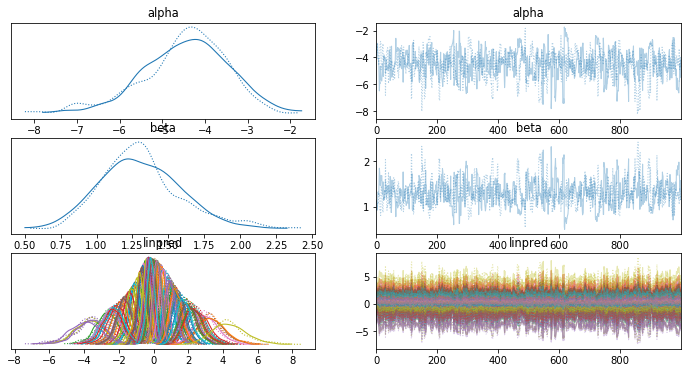

In [13]:
az.plot_trace(fit)
plt.show()

## 2. Binary bivariate classification

In [14]:
#generate bivariate binary data
data_1 = np.random.normal([2.5,2.5],[1,1], [50,2])
data1_x = data_1[:,0]
data1_y = data_1[:,1]

data_2 = np.random.normal([4,4],[1,1], [50,2])
data2_x = data_2[:,0]
data2_y = data_2[:,1]

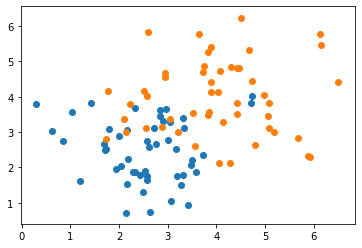

In [15]:
plt.scatter(data1_x, data1_y)
plt.scatter(data2_x, data2_y)
plt.show()

In [16]:
N = 50

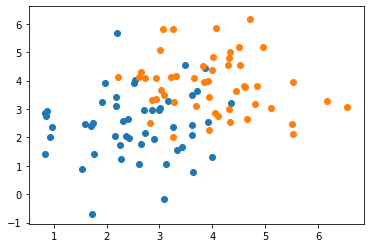

In [17]:
x1 = np.random.normal([2.5,2.5],[1,1], [N,2])
x2 = np.random.normal([4,4],[1,1], [50,2])
plt.scatter(x1[:,0], x1[:,1])
plt.scatter(x2[:,0], x2[:,1])
plt.show()

In [18]:
x_0 = np.concatenate([x1, x2])
y_0 = np.concatenate([np.zeros(N), np.ones(N)]).astype(int)

In [19]:
data = {                                                                                             
    'N': 2*N,                                                                                        
    'K': 2,                                                                                        
    'y': y_0,                                                                                     
    'X': x_0                                                                                             
}  

The same code is valid for more than one independent variable.

In [20]:
posterior = stan.build(code, data=data, random_seed=1)


Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 15, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 16, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be do

In [21]:
fit = posterior.sample(num_chains=2, num_samples=1000)


Sampling:   0%
Sampling:   8% (300/4000)
Sampling:  12% (500/4000)
Sampling:  55% (2200/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!


In [22]:
df = fit.to_frame()  # pandas `DataFrame, requires pandas
print(df.describe().T)

                count       mean        std        min        25%        50%  \
parameters                                                                     
lp__           2000.0 -35.878470   1.273632 -43.045403 -36.438466 -35.544203   
accept_stat__  2000.0   0.937899   0.095631   0.028830   0.917569   0.977301   
stepsize__     2000.0   0.114640   0.010755   0.103887   0.103887   0.114640   
treedepth__    2000.0   3.842000   1.136082   1.000000   3.000000   4.000000   
n_leapfrog__   2000.0  23.497000  14.891402   1.000000  11.000000  23.000000   
...               ...        ...        ...        ...        ...        ...   
linpred.96     2000.0   3.151162   0.721528   0.984327   2.661620   3.119667   
linpred.97     2000.0   5.048479   1.110597   1.997804   4.301139   4.962751   
linpred.98     2000.0   5.808335   1.429808   2.098544   4.861262   5.721368   
linpred.99     2000.0   3.987648   0.849133   1.555090   3.405364   3.924526   
linpred.100    2000.0   1.085186   0.551

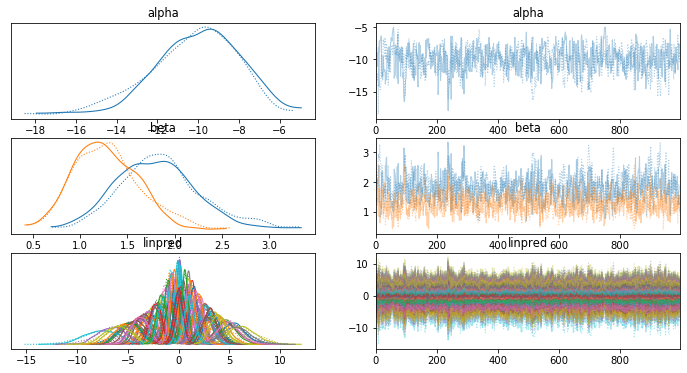

In [23]:
az.plot_trace(fit)
plt.show()